# **Importation des données & exploration du jeu de radiographies**

In [81]:
import sys,os
from PIL import Image
import matplotlib.pyplot as plt
import pandas as pd
from pathlib import Path

In [82]:
DATA_ROOT     = Path("../data/mri_dataset_brain_cancer_oc")
LABELED_DIR   = DATA_ROOT / "avec_labels"
UNLABELED_DIR = DATA_ROOT / "sans_label"

print(DATA_ROOT)
      

..\data\mri_dataset_brain_cancer_oc


## Construciton du dataframe des images

In [84]:
rows = []

# --- Images avec labels ---
for label in ["cancer", "normal"]:
    class_dir = LABELED_DIR / label
    for filename in os.listdir(class_dir):
        if filename.lower().endswith((".jpg", ".jpeg", ".png")):
            rows.append({
                "filepath": str(class_dir / filename),
                "has_label": True,
                "label": label
            })

# --- Images sans labels ---
for filename in os.listdir(UNLABELED_DIR):
    if filename.lower().endswith((".jpg", ".jpeg", ".png")):
        rows.append({
            "filepath": str(UNLABELED_DIR / filename),
            "has_label": False,
            "label": None
        })

df = pd.DataFrame(rows)
df.head()

,filepath,has_label,label
0,..\data\mri_dataset_brain_cancer_oc\avec_label...,True,cancer
1,..\data\mri_dataset_brain_cancer_oc\avec_label...,True,cancer
2,..\data\mri_dataset_brain_cancer_oc\avec_label...,True,cancer
3,..\data\mri_dataset_brain_cancer_oc\avec_label...,True,cancer
4,..\data\mri_dataset_brain_cancer_oc\avec_label...,True,cancer


## Vérificatrion de la distribution des images

In [86]:
from PIL import Image
from collections import Counter

sample_paths = df["filepath"].sample(30, random_state=42)

sizes = []
modes = []

for fp in sample_paths:
    img = Image.open(fp)
    sizes.append(img.size)
    modes.append(img.mode)

print("Résolutions rencontrées :", Counter(sizes))
print("Modes couleur rencontrés :", Counter(modes))


Résolutions rencontrées : Counter({(512, 512): 30})
Modes couleur rencontrés : Counter({'RGB': 30})


## Visualisation d'un échantillon d'images

### Images annotées

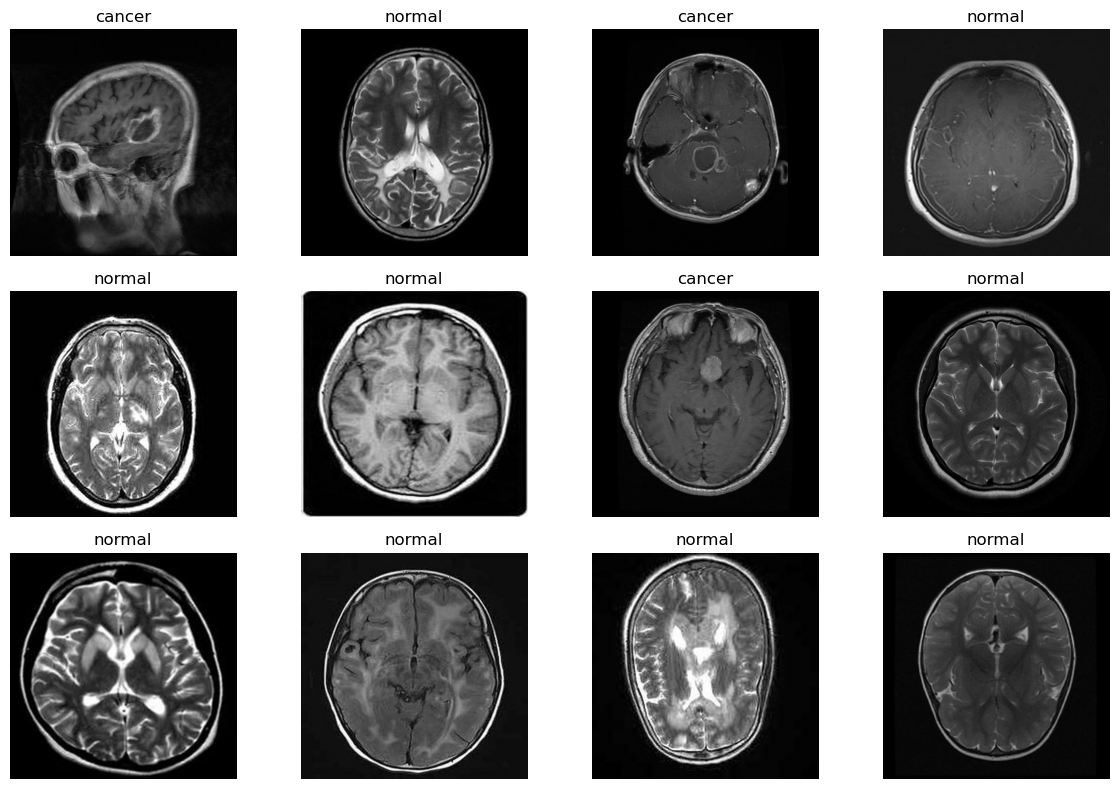

In [89]:
import matplotlib.pyplot as plt
from PIL import Image
import random

subset = df[df["has_label"]].sample(12, random_state=0)

plt.figure(figsize=(12, 8))
for i, (_, row) in enumerate(subset.iterrows()):
    img = Image.open(row["filepath"])
    plt.subplot(3, 4, i+1)
    plt.imshow(img, cmap='gray' if img.mode != "RGB" else None)
    plt.title(f"{row['label']}")
    plt.axis("off")
plt.tight_layout()
plt.show()

### Images non annotées

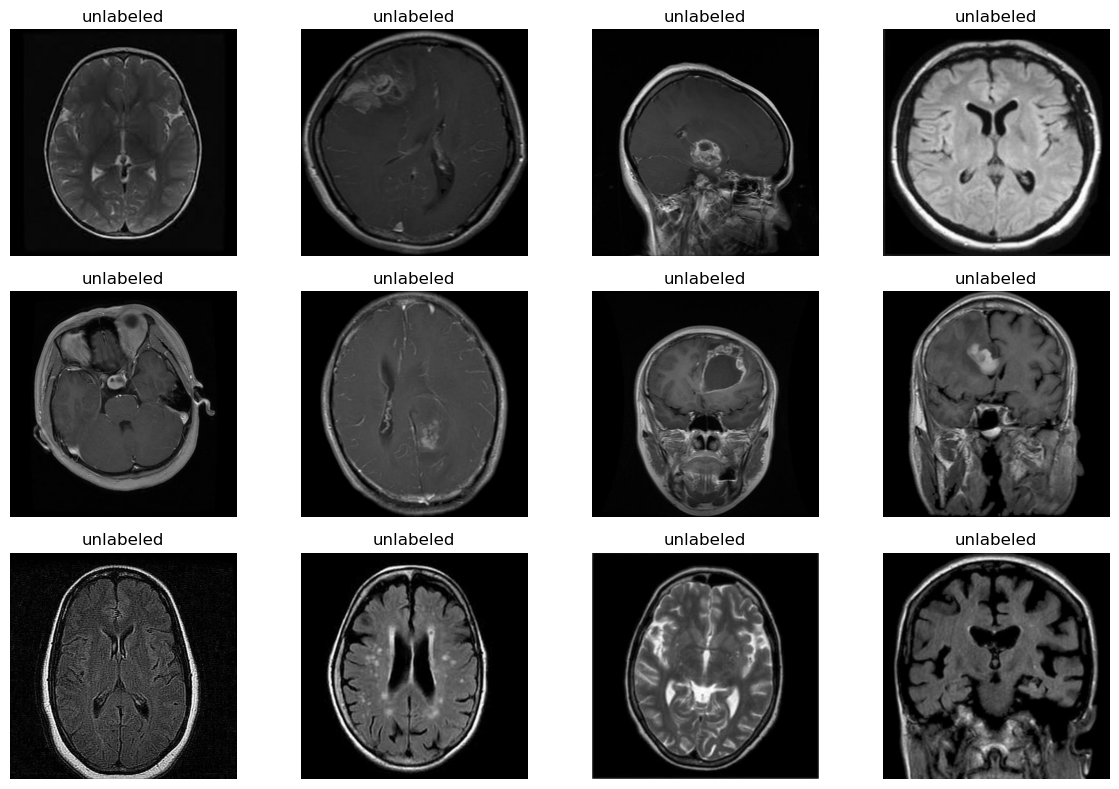

In [91]:
subset = df[~df["has_label"]].sample(12, random_state=0)

plt.figure(figsize=(12, 8))
for i, (_, row) in enumerate(subset.iterrows()):
    img = Image.open(row["filepath"])
    plt.subplot(3, 4, i+1)
    plt.imshow(img, cmap='gray' if img.mode != "RGB" else None)
    plt.title("unlabeled")
    plt.axis("off")
plt.tight_layout()
plt.show()

Structure des données

Le dataset contient 1500 images d’IRM réparties en :

100 images annotées dans avec_labels/ : normal : 50, cancer : 50
1400 images non annotées dans sans_labels/

Format & cohérence

Toutes les images sont au format JPG (.jpg)
Résolution standardisée en 512×512 pixels 
Mode couleur : soit L (niveaux de gris), soit RGB mais équivalent noir/blanc

## Contrôle qualité et cohérence du dataset

In [94]:
from pathlib import Path
from PIL import Image
import pandas as pd

def audit_images(df, max_errors=20):
    records = []
    errors = []

    for i, row in df.iterrows():
        fp = Path(row["filepath"])
        rec = {"filepath": str(fp), "exists": fp.exists()}
        if not fp.exists():
            records.append({**rec, "status": "missing"})
            continue

        try:
            with Image.open(fp) as im:
                rec.update({
                    "status": "ok",
                    "format": im.format,
                    "mode": im.mode,
                    "width": im.size[0],
                    "height": im.size[1],
                })
        except Exception as e:
            rec.update({"status": "error", "error": str(e)})
            errors.append(rec)
            if len(errors) >= max_errors:
                pass

        records.append(rec)

    audit_df = pd.DataFrame(records)
    err_df = pd.DataFrame(errors)
    return audit_df, err_df

audit_df, err_df = audit_images(df)

print("Total:", len(audit_df))
print("Missing:", (audit_df["status"] == "missing").sum())
print("Errors:", (audit_df["status"] == "error").sum())

audit_df[["format","mode","width","height"]].value_counts().head(10)


Total: 1506
Missing: 0
Errors: 0


format  mode  width  height
JPEG    RGB   512    512       1506
Name: count, dtype: int64

Analyse exploratoire du prétraitement (hors pipeline d’entraînement)

Les étapes suivantes (conversion RGB, redimensionnement et égalisation d’histogramme) sont appliquées ici uniquement à des fins d’analyse visuelle.

Elles permettent d’illustrer l’impact de l’égalisation sur le contraste des images IRM.

Ces transformations ne sont pas intégrées au pipeline final d’entraînement, afin de rester cohérent avec les conditions d’apprentissage du backbone ResNet pré-entraîné sur ImageNet.

In [96]:
from PIL import Image

def preprocess_pil_rgb(img, target_size=(224, 224)):
    """
    Normalisation PIL :
    - conversion RGB
    - redimensionnement
    """
    img = img.convert("RGB")
    img = img.resize(target_size)
    return img

In [97]:
from PIL import ImageOps

def equalize_rgb(img):
    """
    Égalisation d'histogramme canal par canal (RGB)
    """
    r, g, b = img.split()
    r_eq = ImageOps.equalize(r)
    g_eq = ImageOps.equalize(g)
    b_eq = ImageOps.equalize(b)
    return Image.merge("RGB", (r_eq, g_eq, b_eq))

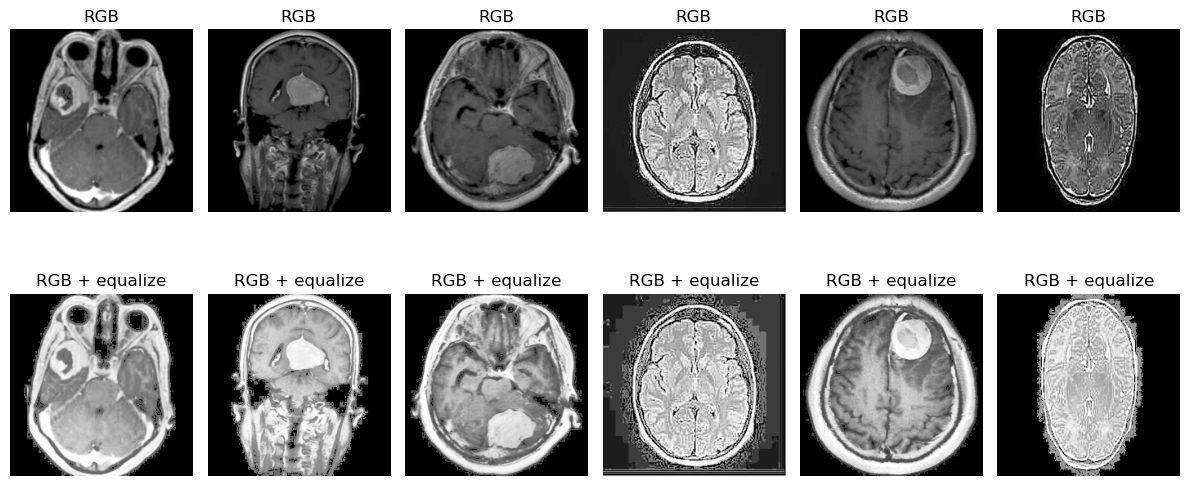

In [98]:
import matplotlib.pyplot as plt

sample = df.sample(6, random_state=42)

plt.figure(figsize=(12,6))
for i, (_, row) in enumerate(sample.iterrows()):
    img = Image.open(row["filepath"])
    img_p = preprocess_pil_rgb(img)
    img_eq = equalize_rgb(img_p)

    plt.subplot(2,6,i+1)
    plt.imshow(img_p)
    plt.title("RGB")
    plt.axis("off")

    plt.subplot(2,6,i+7)
    plt.imshow(img_eq)
    plt.title("RGB + equalize")
    plt.axis("off")

plt.tight_layout()
plt.show()


Ces transformations sont appliquées uniquement à des fins d’analyse visuelle et ne sont pas intégrées au pipeline d’entraînement afin de rester cohérent avec les conditions de pré-entraînement du backbone ResNet50.

# **Prétraitement & extraction des features**

## Préparer les données & transformations

In [102]:
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, models
from PIL import Image

df.head()

,filepath,has_label,label
0,..\data\mri_dataset_brain_cancer_oc\avec_label...,True,cancer
1,..\data\mri_dataset_brain_cancer_oc\avec_label...,True,cancer
2,..\data\mri_dataset_brain_cancer_oc\avec_label...,True,cancer
3,..\data\mri_dataset_brain_cancer_oc\avec_label...,True,cancer
4,..\data\mri_dataset_brain_cancer_oc\avec_label...,True,cancer


## Transforms pour ResNet (ImageNet)

In [104]:
from PIL import ImageOps

def equalize_rgb(img):
    r, g, b = img.split()
    return Image.merge("RGB", (
        ImageOps.equalize(r),
        ImageOps.equalize(g),
        ImageOps.equalize(b)
    ))

image_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.Lambda(lambda img: img.convert("RGB")),
    transforms.Lambda(equalize_rgb),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225]
    )
])

### Choix final du prétraitement

Toutes les images sont converties en RGB et redimensionnées en 224×224 pixels
au moment du chargement via les transforms PyTorch.

L’égalisation d’histogramme a été testée visuellement mais n’a pas été retenue
dans le pipeline final afin de rester cohérent avec le pré-entraînement ImageNet
du backbone ResNet50.


## Dataset PyTorch personnalisé

In [108]:
class MRIDataset(Dataset):
    def __init__(self, df, transform=None):
        self.df = df.reset_index(drop=True)
        self.transform = transform

        # mapping label text -> int (pour plus tard)
        self.label_mapping = {"cancer": 1, "normal": 0}

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        img_path = row["filepath"]
        img = Image.open(img_path).convert("RGB")  # au cas où

        if self.transform is not None:
            img = self.transform(img)

        # label numérique si dispo, sinon -1
        if row["has_label"]:
            label = self.label_mapping[row["label"]]
        else:
            label = -1

        return img, label, img_path

### Dataset & Dataloader

In [110]:
dataset = MRIDataset(df, transform=image_transforms)

batch_size = 32
loader = DataLoader(dataset, batch_size=32, shuffle=False, num_workers=0)

## Analyse des modèles pré-entrainés et choix du backbone principal

Dans la documentation du dataset, plusieurs architectures sont suggérées pour l’analyse d’images médicales, notamment :  
- DenseNet201  
- ResNet50V2  
- VGG16  
- MobileNetV2  
- YOLOv8x/s  
  
Avant de procéder à l’extraction des features, il est important d’analyser ces modèles afin de sélectionner un backbone adapté au contexte du projet.

### Analyse préliminaire de quelques modèles

| Modèle          | Avantages                                                                                                                                 | Limites                         | Pertinence dans ce projet                                          |
| --------------- | ----------------------------------------------------------------------------------------------------------------------------------------- | ------------------------------- | ------------------------------------------------------------------ |
| **ResNet50V2**  | Architecture profonde, stable, très utilisée en imagerie médicale ; CNN résiduel de haute qualité ; bon compromis entre précision et coût | Plus lent que ResNet18          | Famille ResNet recommandée dans la documentation (inclut ResNet50/50V2) → **excellent choix principal** |
| **DenseNet201** | Très riche en features, très bon en médical                                                                                               | Très lourd, extraction lente    | À tester éventuellement                                            |
| **VGG16**       | Simple, robuste, baseline connue                                                                                                          | Très lourd, obsolète            | Peu pertinent comme backbone principal                             |
| **MobileNetV2** | Léger, rapide, idéal pour passage à l’échelle                                                                                             | Moins précis                    | Très bon candidat secondaire                                       |
| **YOLOv8**      | Détection d’objets                                                                                                                        | Pas pour classification globale | Non adapté ici                                                     |

### Justification du choix de ResNet50V2

ResNet50V2 apparaît comme un choix naturel pour ce projet car :  
- il est explicitement mentionné dans les notes du dataset,  
- il est réputé pour sa stabilité et son efficacité sur les images médicales,  
- il produit des embeddings riches (2048 dimensions),  
- il est facilement accessible via l’API Keras,  
- il constitue un excellent compromis entre performance et temps de calcul.
  
Pour ces raisons, ResNet50V2 sera utilisé comme backbone principal pour l’extraction des caractéristiques.  
Dans un second temps, une comparaison rapide pourra être réalisée avec MobileNetV2 ou DenseNet201, afin de valider ou affiner ce choix.

## Charger un modèle pré-entraîné (ResNet)

In [118]:
import torch
from torchvision.models import resnet50, ResNet50_Weights

# Charger les poids ImageNet pour ResNet50
weights = ResNet50_Weights.IMAGENET1K_V2
base_model = resnet50(weights=weights)

# On enlève la dernière couche de classification pour ne garder que les features
# Résultat : embeddings de dimension 2048
feature_extractor = torch.nn.Sequential(*list(base_model.children())[:-1])

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
feature_extractor = feature_extractor.to(device)
feature_extractor.eval()

# L’extraction se fait sur CPU, ce qui explique le temps d’exécution modéré.
print("Device utilisé :", device)

Device utilisé : cpu


In [119]:
# Pas de finetunning
for param in feature_extractor.parameters():
    param.requires_grad = False

print("done")

done


## Extraction des embeddings pour toutes les images

In [121]:
import numpy as np

all_features = []
all_labels = []
all_paths = []

with torch.no_grad():
    for imgs, labels, paths in loader:
        imgs = imgs.to(device)

        # Sortie: (batch_size, 2048, 1, 1) pour ResNet50
        feats = feature_extractor(imgs)

        feats = feats.view(feats.size(0), -1)

        all_features.append(feats.cpu().numpy())
        all_labels.append(labels.numpy())
        all_paths.extend(paths)

# Concaténer tous les batchs
all_features = np.concatenate(all_features, axis=0)   
all_labels = np.concatenate(all_labels, axis=0)       
print("done")

done


## Création d'un dataframe de features

In [123]:
feature_dim = all_features.shape[1]
feature_cols = [f"f_{i}" for i in range(feature_dim)]

features_df = pd.DataFrame(all_features, columns=feature_cols)
features_df["filepath"] = all_paths
features_df["label_num"] = all_labels

# Merge avec df original pour récupérer has_label et label texte
df_features = df.merge(features_df, on="filepath")

df_features.head()

,filepath,has_label,label,f_0,f_1,f_2,f_3,f_4,f_5,f_6,...,f_2039,f_2040,f_2041,f_2042,f_2043,f_2044,f_2045,f_2046,f_2047,label_num
0,..\data\mri_dataset_brain_cancer_oc\avec_label...,True,cancer,0.020170,0.081777,0.910693,0.018377,0.227473,0.001367,0.610081,...,0.004800,0.038811,0.038559,0.247082,0.136933,0.494078,0.029890,0.00000,0.417818,1
1,..\data\mri_dataset_brain_cancer_oc\avec_label...,True,cancer,0.000000,0.000000,0.046374,0.000000,0.016989,0.000000,0.100139,...,0.000000,0.018771,0.000000,0.072961,0.426347,0.082237,0.000000,0.00000,0.000000,1
2,..\data\mri_dataset_brain_cancer_oc\avec_label...,True,cancer,0.038236,0.000000,0.224883,0.000000,0.000000,0.000000,0.103324,...,0.000000,0.000000,0.000000,0.000000,0.731794,0.356936,0.000000,0.00000,0.000000,1
3,..\data\mri_dataset_brain_cancer_oc\avec_label...,True,cancer,0.000000,0.047194,0.000000,0.000000,0.008151,0.000000,0.061417,...,0.172062,0.000000,0.096277,0.193900,0.134569,0.247603,0.015533,0.13964,0.032774,1
4,..\data\mri_dataset_brain_cancer_oc\avec_label...,True,cancer,0.031642,0.001197,0.333595,0.000000,0.223293,0.022146,0.443905,...,0.104627,0.000000,0.000000,0.023083,0.334516,0.098433,0.000000,0.00000,0.065909,1


## Sauvegarde

In [125]:
# Version parquet
df_features.to_parquet("../data/brain_features_resnet50.parquet", index=False)

## Vérifications

In [127]:
# Shape
df_features.shape

(1506, 2052)

In [128]:
# Dispersion des features
df_features[[f"f_{i}" for i in range(feature_dim)]].std().mean()

0.12917602

array([[<Axes: title={'center': 'f_0'}>, <Axes: title={'center': 'f_1'}>,
        <Axes: title={'center': 'f_2'}>],
       [<Axes: title={'center': 'f_3'}>, <Axes: title={'center': 'f_4'}>,
        <Axes: title={'center': 'f_5'}>],
       [<Axes: title={'center': 'f_6'}>, <Axes: title={'center': 'f_7'}>,
        <Axes: title={'center': 'f_8'}>],
       [<Axes: title={'center': 'f_9'}>, <Axes: >, <Axes: >]],
      dtype=object)

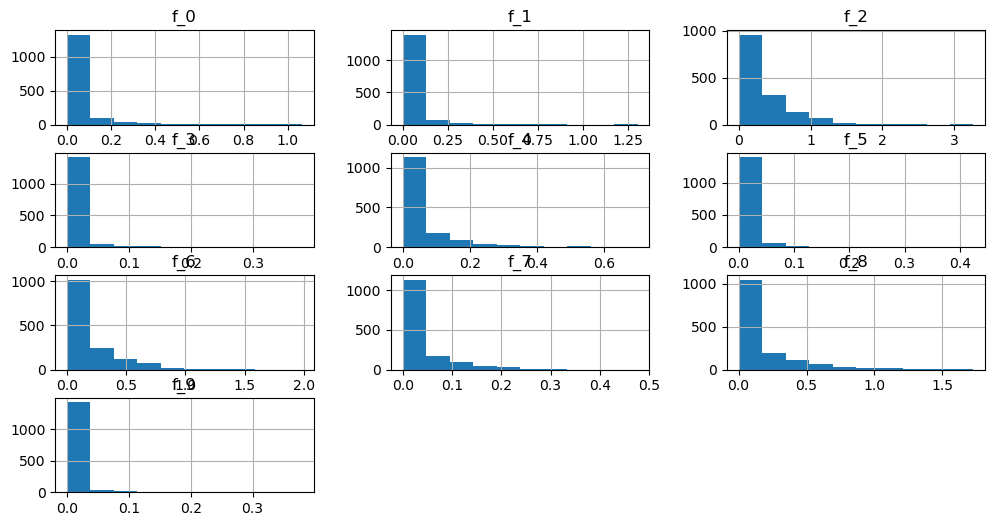

In [129]:
# Distribution embeddings
df_features[[f"f_{i}" for i in range(10)]].hist(figsize=(12,6))

In [130]:
# Diversité embeddings
df_features[[f"f_{i}" for i in range(511)]].std().mean()

0.13321155

In [131]:
""

''